In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import sys
import shutil
sys.path.append("../BIRADS_classifier")
os.chdir("../BIRADS_classifier")

In [2]:
from birads_prediction_torch import inference

In [3]:
model_path = "saved_models/model.p"
device_type = "gpu"
gpu_number = 0
input_size = (2048, 2048)

In [4]:
df = pd.read_csv("../rsna_mammo/fold/train_with_fold.csv")

In [5]:
image_path_dict = {}
for idx, row in tqdm(df.iterrows()):
    patient_id = row["patient_id"]
    image_id = row["image_id"]
    view = row["view"]
    laterality = row["laterality"]
    if patient_id not in image_path_dict:
        image_path_dict[patient_id] = {}
    image_path_dict[patient_id][f"{laterality}-{view}"] = image_id

54706it [00:03, 17191.43it/s]


In [6]:
def rename_image_tmp(patient_id):
    image_dir = Path("../data") / str(patient_id)
    image_path_l_cc = image_dir / (f'{image_path_dict[patient_id]["L-CC"]}'+".png")
    image_path_l_mlo = image_dir / (f'{image_path_dict[patient_id]["L-MLO"]}'+".png")
    image_path_r_cc = image_dir / (f'{image_path_dict[patient_id]["R-CC"]}'+".png")
    image_path_r_mlo = image_dir / (f'{image_path_dict[patient_id]["R-MLO"]}'+".png")
    tmp_dir = Path(f"./tmp_{patient_id}")
    tmp_dir.mkdir(exist_ok=True)
    shutil.copyfile(image_path_l_cc, tmp_dir / "L-CC.png")
    shutil.copyfile(image_path_l_mlo, tmp_dir / "L-MLO.png")
    shutil.copyfile(image_path_r_cc, tmp_dir / "R-CC.png")
    shutil.copyfile(image_path_r_mlo, tmp_dir / "R-MLO.png")

In [43]:
idx_list = df[(df["fold"]==0)]["patient_id"].unique()

In [27]:
patient_id = idx_list[0]
rename_image_tmp(patient_id)
image_path = f"./tmp_{patient_id}/"

In [47]:
birads_pred = []
for idx in tqdm(range(len(idx_list))):
    patient_id = idx_list[idx]
    rename_image_tmp(patient_id)
    image_path = f"./tmp_{patient_id}/"
    parameters = {
            "model_path": model_path,
            "device_type": device_type,
            "gpu_number": gpu_number,
            "image_path": image_path,
            "input_size": input_size,
        }
    res = inference(parameters, False)
    birads_pred.append(res)
    shutil.rmtree(image_path)

100%|██████████| 2978/2978 [14:49<00:00,  3.35it/s]


In [58]:
birads_pred = np.array(birads_pred)

In [49]:
df_0 = df[df["fold"]==0]

In [66]:
df_birads_pred = pd.DataFrame(data=birads_pred)
df_birads_pred["patient_id"] = idx_list

In [71]:
# df_birads_pred.to_csv("../birads_pred_fold_0.csv", index=False)

In [72]:
df_0 = df_0.groupby(by="patient_id").max().reset_index()

In [76]:
df_0 = df_0.merge(df_birads_pred, on="patient_id")

<AxesSubplot:>

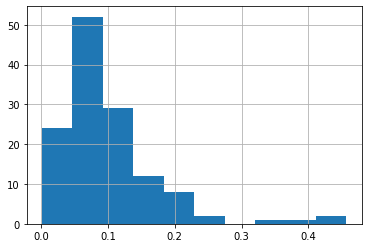

In [80]:
# 正例のBIRADS=0の予測値
df_0[df_0["cancer"]==1][0].hist()

<AxesSubplot:>

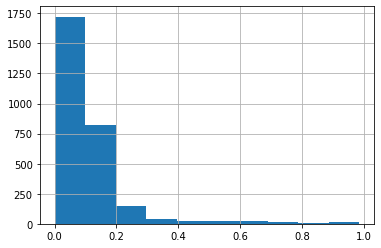

In [83]:
# 負例のBIRADS=0の予測値
df_0[df_0["cancer"]==0][0].hist()

<AxesSubplot:>

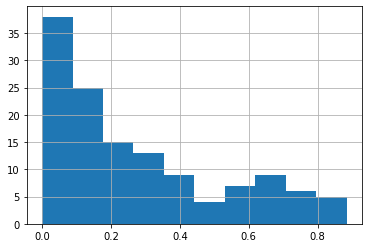

In [81]:
# 正例のBIRADS=1の予測値
df_0[df_0["cancer"]==1][1].hist()

<AxesSubplot:>

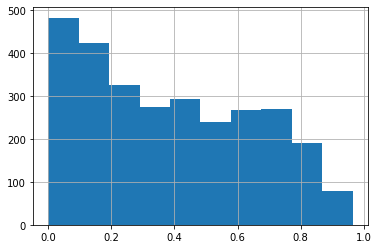

In [84]:
# 負例のBIRADS=1の予測値
df_0[df_0["cancer"]==0][1].hist()

<AxesSubplot:>

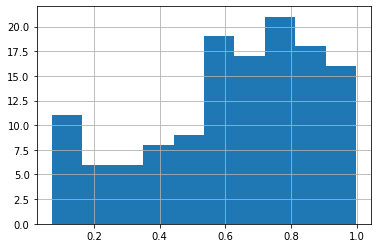

In [82]:
# 正例のBIRADS=2の予測値
df_0[df_0["cancer"]==1][2].hist()

<AxesSubplot:>

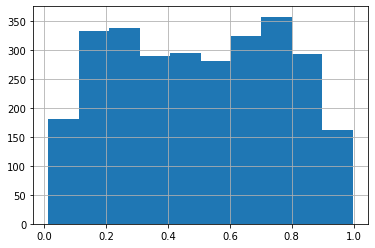

In [85]:
# 負例のBIRADS=2の予測値
df_0[df_0["cancer"]==0][2].hist()